# SCOAP3 calcultaion of contributors ratio per institution

Notebook created to import the data from the SCOAP3 tepository and obtain the contribution ratio per isntitution

* Authors: Pablo Iriarte (pablo.iriarte@unige.ch), Jean-Blaise Claivaz (jean-blaise.claivaz@unige.ch) & Eric Silva Quintana (eric.silvaquintana@unige.ch), UNIGE

* First version: 10.03.2019
* Last update: 15.03.2024
* Licence: CC-BY

## Initial values and parameters

In [1]:
# dépendences
import os
import pandas as pd
import json
import requests
from tqdm import tqdm
import codecs

# dates prise en compte
date_debut = '2022'
date_fin = '2023'
country = 'switzerland'

# URL du répo
searchurl = 'https://repo.scoap3.org/api/records/?q=country:' + country + '&year=' + date_debut + '--' + date_fin

# fichier avec la liste des variantes des affiliations par institution
fichier_affiliations = 'affiliations_mapping.tsv'

# dossiers pour l'enregistrement des fichiers produits
data_import_folder = 'imports'
data_parsed_folder = 'parsed'
results_folder = 'results'

# fichiers où seront exportés les données extraits du répo Scoap3
publications = data_parsed_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_publications.tsv'
affiliations = data_parsed_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_affiliations.tsv'

# fichiers où seront exportés les résultats
results_ratios = results_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_ratios.tsv'
results_numbers = results_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_numbers.tsv'
affiliations_not_matched = results_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_affiliations_not_matched.txt'
affiliations_missing = results_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_affiliations_missing.txt'

# importer les données depuis le repository SCOAP3 [0,1] : mettre à 0 si l'import a déjà été fait
do_import = 1

# faire la boucle d'extraction [0,1] : mettre à 0 si l'extraction a déjà été faite
do_parse = 1

C:\Users\iriarte\AppData\Local\Continuum\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (5.1.0) doesn't match a supported version!
  RequestsDependencyWarning)


## Folder creation

In [2]:
if not os.path.exists(data_import_folder):
    os.makedirs(data_import_folder)

In [3]:
if not os.path.exists(data_parsed_folder):
    os.makedirs(data_parsed_folder)

In [4]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

## Import of JSON files from SCOAP3 repository

In [5]:
# obtenir le total
def get_total(url):
    headers = {'Accept': 'application/json'}
    url_next = ''
    resp = requests.get(url, headers=headers)
    # print(resp)
    if (resp.status_code == 200) :
        # export
        with open(data_import_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_page_0000.json', 'w', encoding='utf-8') as f:
            f.write(resp.text)
        data_json = resp.json()
        if 'next' in data_json['links'] :
            url_next = data_json['links']['next']
        if 'total' in data_json['hits'] :
            total = data_json['hits']['total']
            print (str(total) + ' documents found for ' + country + ' between ' + date_debut + ' and ' + date_fin)
            print ('####################################')
            print ('Page 0 - DONE')
            return(total, url_next)
        else :
            print ('0 documents trouvés pour ' + country + ' entre ' + date_debut + ' et ' + date_fin)
            print ('Page 1 - DONE')
            return(0, url_next)
    else :
        print ('0 documents trouvés pour ' + country + ' entre ' + date_debut + ' et ' + date_fin)
        print ('Page 1 - ERROR - ' + url)
        return(0, url_next)

In [6]:
def import_json(url, page):
    headers = {'Accept': 'application/json'}
    resp = requests.get(url, headers=headers)
    # print(resp)
    if (resp.status_code == 200) :
        # export
        with open(data_import_folder + '/scoap3_' + country + '_' + date_debut + '_' + date_fin + '_page_' + str(page).zfill(4) + '.json', 'w', encoding='utf-8') as f:
            f.write(resp.text)
        data_json = resp.json()
        if 'next' in data_json['links'] :
            url_next = data_json['links']['next']
            print ('Page ' + str(page) + ' - DONE')
            return(url_next)
        else :
            print ('Page ' + str(page) + ' - DONE')
            print ('End of pages')
            return('')
    else :
        print ('Page ' + str(page) + ' - ERROR - ' + url)
        return('')

In [7]:
if (do_import == 1) :
    page_counter = 1
    # import initial et obtention du total
    total, next_page_url = get_total(searchurl)
    if ((int(total) > 0) & (next_page_url != '')) :
        # print(next_page)
        while (next_page_url != ''):
            next_page_url = import_json(next_page_url, page_counter)
            page_counter = page_counter + 1

972 documents found for switzerland between 2022 and 2023
####################################
Page 0 - DONE
Page 1 - DONE
Page 2 - DONE
Page 3 - DONE
Page 4 - DONE
Page 5 - DONE
Page 6 - DONE
Page 7 - DONE
Page 8 - DONE
Page 9 - DONE
Page 10 - DONE
Page 11 - DONE
Page 12 - DONE
Page 13 - DONE
Page 14 - DONE
Page 15 - DONE
Page 16 - DONE
Page 17 - DONE
Page 18 - DONE
Page 19 - DONE
Page 20 - DONE
Page 21 - DONE
Page 22 - DONE
Page 23 - DONE
Page 24 - DONE
Page 25 - DONE
Page 26 - DONE
Page 27 - DONE
Page 28 - DONE
Page 29 - DONE
Page 30 - DONE
Page 31 - DONE
Page 32 - DONE
Page 33 - DONE
Page 34 - DONE
Page 35 - DONE
Page 36 - DONE
Page 37 - DONE
Page 38 - DONE
Page 39 - DONE
Page 40 - DONE
Page 41 - DONE
Page 42 - DONE
Page 43 - DONE
Page 44 - DONE
Page 45 - DONE
Page 46 - DONE
Page 47 - DONE
Page 48 - DONE
Page 49 - DONE
Page 50 - DONE
Page 51 - DONE
Page 52 - DONE
Page 53 - DONE
Page 54 - DONE
Page 55 - DONE
Page 56 - DONE
Page 57 - DONE
Page 58 - DONE
Page 59 - DONE
Page 60 - DONE


## Parsing of imported JSON files and export of publications and affiliation data

In [8]:
# publications
if (do_parse == 1):
    # creation of file
    file_publications = open(publications, mode='w', encoding='utf-8')
   
    # write first line
    file_publications.write('publication_id\tpublication_year\tpublication_created\tpublication_updated\tauthors_n\taffiliations_n\n')

    # folder of imported failes
    files = os.listdir(data_import_folder)
    # print(files)
    
    # ids
    publication_ids = []
    publication_ids_dubbles = []

    # loop on files
    for file in tqdm(files):        
        # open of json file
        with open(data_import_folder + '/' + file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if not data['hits']['hits']:
                break
            # parsing publications
            for hit in data['hits']['hits']:
                # initialise of extracting values for publications
                publication_id = ''
                publication_year = ''
                publication_created = ''
                publication_updated = ''
                authors_n = 0
                affiliations_n = 0
                if ('id' in hit) :
                    publication_id = hit['id']
                    if (publication_id not in publication_ids):
                        publication_ids.append(publication_id)
                        if ('year' in hit['metadata']) :
                            publication_year = hit['metadata']['year']
                        if ('created' in hit) :
                            publication_created = hit['created']
                        if ('updated' in hit) :
                            publication_updated = hit['updated']
                        if ('authors' in hit['metadata']):
                            for hit_author in hit['metadata']['authors']:
                                authors_n = authors_n + 1
                                if ('affiliations' in hit_author):
                                    for author_affiliation in hit_author['affiliations']:
                                        affiliations_n = affiliations_n + 1
                        # write the data in file
                        file_publications.write(str(publication_id))
                        file_publications.write('\t')
                        file_publications.write(publication_year)
                        file_publications.write('\t')
                        file_publications.write(publication_created)
                        file_publications.write('\t')
                        file_publications.write(publication_updated)
                        file_publications.write('\t')
                        file_publications.write(str(authors_n))
                        file_publications.write('\t')
                        file_publications.write(str(affiliations_n))
                        file_publications.write('\n')
                    else:
                        publication_ids_dubbles.append(publication_id)
                        # print('ERROR ' + str(publication_id) + ' already found')
        f.close()
    file_publications.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.07it/s]


In [9]:
print('publications parsed: ' + str(len(publication_ids)))

publications parsed: 972


In [10]:
print('publications found that was already parsed: ' + str(len(publication_ids_dubbles)))

publications found that was already parsed: 962


In [11]:
# publications
if (do_parse == 1):
    # creation of file
    file_affiliations = open(affiliations, mode='w', encoding='utf-8')
   
    # write first line
    file_affiliations.write('publication_id\tauthor_id\taffiliation_id\tratio\taffiliation_country\taffiliation_value\n')

    # folder of imported failes
    files = os.listdir(data_import_folder)
    # print(files)
    
    # ids
    publication_ids = []
    publication_ids_dubbles = []
    ratio_total = 0

    # loop on files
    for file in tqdm(files):        
        # open of json file
        with open(data_import_folder + '/' + file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if not data['hits']['hits']:
                break
            # parsing publications
            for hit in data['hits']['hits']:
                # initialise of extracting values for publications
                publication_id = ''
                publication_year = ''
                publication_created = ''
                publication_updated = ''
                authors_id = ''
                authors_n = 0
                authors_i = 0
                authors_ratio = 0
                affiliations_id = ''
                affiliations_n = 0
                affiliations_i = 0
                affiliations_ratio = 0
                ratio = 0
                affiliation_country = ''
                affiliation_value = ''
                if ('id' in hit) :
                    publication_id = hit['id']
                    if (publication_id not in publication_ids):
                        publication_ids.append(publication_id)
                        if ('year' in hit['metadata']) :
                            publication_year = hit['metadata']['year']
                        if ('created' in hit) :
                            publication_created = hit['created']
                        if ('updated' in hit) :
                            publication_updated = hit['updated']
                        if ('authors' in hit['metadata']):
                            authors_i = 0
                            for hit_author in hit['metadata']['authors']:
                                authors_n = authors_n + 1
                            authors_ratio = 1/authors_n
                            for hit_author in hit['metadata']['authors']:
                                authors_i = authors_i + 1
                                authors_id = str(publication_id) + '-' + str(authors_i)
                                if ('affiliations' in hit_author):
                                    affiliations_n = 0
                                    affiliations_i = 0
                                    affiliations_ratio = 0
                                    ratio = 0
                                    for author_affiliation in hit_author['affiliations']:
                                        affiliations_n = affiliations_n + 1
                                    affiliations_ratio = 1/affiliations_n
                                    ratio = authors_ratio * affiliations_ratio
                                    for author_affiliation in hit_author['affiliations']:
                                        ratio_total = ratio_total + ratio
                                        affiliation_country = ''
                                        affiliation_value = ''
                                        affiliations_i = affiliations_i + 1
                                        affiliations_id = str(authors_id) + '-' + str(affiliations_i)
                                        if ('country' in author_affiliation):
                                            affiliation_country = author_affiliation['country']
                                        if ('value' in author_affiliation):
                                            affiliation_value = author_affiliation['value']
                                        # write the data in file
                                        file_affiliations.write(str(publication_id))
                                        file_affiliations.write('\t')
                                        file_affiliations.write(authors_id)
                                        file_affiliations.write('\t')
                                        file_affiliations.write(affiliations_id)
                                        file_affiliations.write('\t')
                                        file_affiliations.write(str(ratio))
                                        file_affiliations.write('\t')
                                        file_affiliations.write(str(affiliation_country))
                                        file_affiliations.write('\t')
                                        file_affiliations.write(str(affiliation_value))
                                        file_affiliations.write('\n')
                                else:
                                    # print('ERROR ' + str(publication_id) + ' affiliation missing')
                                    affiliations_n = 0
                                    affiliations_i = 0
                                    affiliations_ratio = 0
                                    ratio = authors_ratio
                                    ratio_total = ratio_total + ratio
                                    affiliation_country = ''
                                    affiliation_value = ''
                                    affiliations_i = affiliations_i + 1
                                    affiliations_id = str(authors_id) + '-' + str(affiliations_i)
                                    # write the data in file
                                    file_affiliations.write(str(publication_id))
                                    file_affiliations.write('\t')
                                    file_affiliations.write(authors_id)
                                    file_affiliations.write('\t')
                                    file_affiliations.write(affiliations_id)
                                    file_affiliations.write('\t')
                                    file_affiliations.write(str(ratio))
                                    file_affiliations.write('\t')
                                    file_affiliations.write(str(affiliation_country))
                                    file_affiliations.write('\t')
                                    file_affiliations.write(str(affiliation_value))
                                    file_affiliations.write('\n')
                    else:
                        publication_ids_dubbles.append(publication_id)
                        # print('ERROR ' + str(publication_id) + ' already found')
        f.close()
    file_affiliations.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.88it/s]


In [12]:
print('publications parsed: ' + str(len(publication_ids)))

publications parsed: 972


In [13]:
print('publications found that was already parsed: ' + str(len(publication_ids_dubbles)))

publications found that was already parsed: 962


In [14]:
print('ratio total: ' + str(ratio_total))

ratio total: 971.999999999622


## Traitement des affiliations et des auteurs

In [15]:
# importer les données exportés dans 2 dataframes
df_publications = pd.read_csv(publications, sep='\t')
df_affiliations = pd.read_csv(affiliations, sep='\t')

In [16]:
df_publications

,publication_id,publication_year,publication_created,publication_updated,authors_n,affiliations_n
0,82603,2023,2024-01-09T06:30:19.740724+00:00,2024-02-03T18:30:54.479677+00:00,4,7
1,82525,2023,2024-01-04T21:30:33.101261+00:00,2024-02-06T18:31:13.514940+00:00,4,6
2,82539,2023,2024-01-05T12:30:39.776775+00:00,2024-01-05T12:30:45.372643+00:00,2948,3148
3,82538,2023,2024-01-05T12:30:39.654096+00:00,2024-01-05T12:30:40.273359+00:00,5,5
4,82534,2023,2024-01-05T09:30:29.836821+00:00,2024-01-05T09:30:33.928662+00:00,2325,2541
...,...,...,...,...,...,...
967,67072,2022,2022-01-08T09:30:40.309642+00:00,2022-05-18T15:16:34.102495+00:00,2,3
968,67051,2022,2022-01-07T18:30:30.034938+00:00,2022-04-05T10:06:58.480464+00:00,7,7
969,66565,2022,2021-12-14T00:31:37.009290+00:00,2022-01-07T09:49:02.154955+00:00,2874,3096
970,66233,2022,2021-11-29T15:30:21.938880+00:00,2022-01-07T09:48:56.572004+00:00,4,4


In [17]:
df_affiliations

,publication_id,author_id,affiliation_id,ratio,affiliation_country,affiliation_value
0,82603,82603-1,82603-1-1,0.125000,Switzerland,"Department of Theoretical Physics, Center for ..."
1,82603,82603-1,82603-1-2,0.125000,Switzerland,"Gravitational Wave Science Center (GWSC), Univ..."
2,82603,82603-2,82603-2-1,0.250000,France,"École Polytechnique, Palaiseau Cedex, France"
3,82603,82603-3,82603-3-1,0.250000,Greece,"Physics Division, National Technical Universit..."
4,82603,82603-4,82603-4-1,0.083333,Switzerland,"Department of Theoretical Physics, Center for ..."
...,...,...,...,...,...,...
1014345,67002,67002-2882,67002-2882-1,0.000347,Germany,"II. Physikalisches Institut, Georg-August-Univ..."
1014346,67002,67002-2883,67002-2883-1,0.000347,UK,"Department of Physics and Astronomy, Universit..."
1014347,67002,67002-2884,67002-2884-1,0.000347,USA,"Enrico Fermi Institute, University of Chicago,..."
1014348,67002,67002-2885,67002-2885-1,0.000347,USA,"Nevis Laboratory, Columbia University, Irvingt..."


## Ajout du code des institutions suisses participant à SCOAP3

Match des lignes par le nom des affiliations normalisées

In [18]:
# ouverture du fichier excel avec les variantes des affiliations
# affiliations = pd.read_excel('Institutions.xlsx', sheet_name='Feuil1', usecols=('Code', 'Affiliation'))
variantes_affiliations = pd.read_csv(fichier_affiliations, sep='\t', header=None)
# renomer les colones
variantes_affiliations = variantes_affiliations.rename(columns={0: 'Affiliation', 1: 'Code'})
variantes_affiliations

,Affiliation,Code
0,Department of Theoretical Physics and Center f...,UNIGE
1,"AEC-LHEP, University of Bern, Bern, Switzerland",UNIBE
2,Albert Einstein Center for Fundamental Physics...,UNIBE
3,Albert Einstein Center for Fundamental Physics...,UNIBE
4,Albert Einstein Center for Fundamental Physics...,UNIBE
...,...,...
287,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...,UNIGE
288,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...,UZH
289,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...,UNIL
290,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...,UNIGE


In [19]:
# Normalisation du nom de l'affiliation pour améliorer le match
import unidecode
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_value'].str.normalize('NFKC').str.upper().str.strip()
variantes_affiliations['affiliation_norm'] = variantes_affiliations['Affiliation'].str.normalize('NFKC').str.upper().str.strip()

In [20]:
# remplacement des accents
df_affiliations['affiliation_norm'] = df_affiliations.apply(lambda x: unidecode.unidecode(str(x.affiliation_norm)), axis=1)
variantes_affiliations['affiliation_norm'] = variantes_affiliations.apply(lambda x: unidecode.unidecode(str(x.affiliation_norm)), axis=1)

In [21]:
df_affiliations['affiliation_norm']

0          DEPARTMENT OF THEORETICAL PHYSICS, CENTER FOR ...
1          GRAVITATIONAL WAVE SCIENCE CENTER (GWSC), UNIV...
2               ECOLE POLYTECHNIQUE, PALAISEAU CEDEX, FRANCE
3          PHYSICS DIVISION, NATIONAL TECHNICAL UNIVERSIT...
4          DEPARTMENT OF THEORETICAL PHYSICS, CENTER FOR ...
                                 ...                        
1014345    II. PHYSIKALISCHES INSTITUT, GEORG-AUGUST-UNIV...
1014346    DEPARTMENT OF PHYSICS AND ASTRONOMY, UNIVERSIT...
1014347    ENRICO FERMI INSTITUTE, UNIVERSITY OF CHICAGO,...
1014348    NEVIS LABORATORY, COLUMBIA UNIVERSITY, IRVINGT...
1014349                            CERN, GENEVA, SWITZERLAND
Name: affiliation_norm, Length: 1014350, dtype: object

In [22]:
variantes_affiliations['affiliation_norm']

0      DEPARTMENT OF THEORETICAL PHYSICS AND CENTER F...
1        AEC-LHEP, UNIVERSITY OF BERN, BERN, SWITZERLAND
2      ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
3      ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
4      ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
                             ...                        
287    ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...
288    INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...
289    DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...
290    D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...
291    ASTRONOMY DEPARTMENT UNIVERSITY OF GENEVE CH D...
Name: affiliation_norm, Length: 292, dtype: object

In [23]:
# supprimer la ponctuation
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('.', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace(',', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace(':', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace(';', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('-', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('?', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('!', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('\'', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('\"', '')
df_affiliations['affiliation_norm'] = df_affiliations['affiliation_norm'].str.replace('  ', ' ')

variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('.', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace(',', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace(':', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace(';', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('-', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('?', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('!', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('\'', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('\"', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('  ', ' ')

df_affiliations['affiliation_norm']

0          DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...
1          GRAVITATIONAL WAVE SCIENCE CENTER (GWSC) UNIVE...
2                 ECOLE POLYTECHNIQUE PALAISEAU CEDEX FRANCE
3          PHYSICS DIVISION NATIONAL TECHNICAL UNIVERSITY...
4          DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...
                                 ...                        
1014345    II PHYSIKALISCHES INSTITUT GEORGAUGUSTUNIVERSI...
1014346    DEPARTMENT OF PHYSICS AND ASTRONOMY UNIVERSITY...
1014347    ENRICO FERMI INSTITUTE UNIVERSITY OF CHICAGO C...
1014348    NEVIS LABORATORY COLUMBIA UNIVERSITY IRVINGTON...
1014349                              CERN GENEVA SWITZERLAND
Name: affiliation_norm, Length: 1014350, dtype: object

In [24]:
variantes_affiliations

,Affiliation,Code,affiliation_norm
0,Department of Theoretical Physics and Center f...,UNIGE,DEPARTMENT OF THEORETICAL PHYSICS AND CENTER F...
1,"AEC-LHEP, University of Bern, Bern, Switzerland",UNIBE,AECLHEP UNIVERSITY OF BERN BERN SWITZERLAND
2,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
3,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
4,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
...,...,...,...
287,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...,UNIGE,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...
288,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...,UZH,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...
289,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...,UNIL,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...
290,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...,UNIGE,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...


In [25]:
# reduire les affiliations pour ne pas avoir plusieurs lignes avec le même nom
variantes_affiliations = variantes_affiliations.drop_duplicates(subset='affiliation_norm')
variantes_affiliations

,Affiliation,Code,affiliation_norm
0,Department of Theoretical Physics and Center f...,UNIGE,DEPARTMENT OF THEORETICAL PHYSICS AND CENTER F...
1,"AEC-LHEP, University of Bern, Bern, Switzerland",UNIBE,AECLHEP UNIVERSITY OF BERN BERN SWITZERLAND
2,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
3,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
4,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
...,...,...,...
287,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...,UNIGE,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...
288,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...,UZH,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...
289,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...,UNIL,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...
290,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...,UNIGE,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...


In [26]:
# Merge final pour ajouter le code de l'institution
df = pd.merge(df_affiliations, variantes_affiliations, how='left', on='affiliation_norm')
df

,publication_id,author_id,affiliation_id,ratio,affiliation_country,affiliation_value,affiliation_norm,Affiliation,Code
0,82603,82603-1,82603-1-1,0.125000,Switzerland,"Department of Theoretical Physics, Center for ...",DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...,NaN,NaN
1,82603,82603-1,82603-1-2,0.125000,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",GRAVITATIONAL WAVE SCIENCE CENTER (GWSC) UNIVE...,NaN,NaN
2,82603,82603-2,82603-2-1,0.250000,France,"École Polytechnique, Palaiseau Cedex, France",ECOLE POLYTECHNIQUE PALAISEAU CEDEX FRANCE,NaN,NaN
3,82603,82603-3,82603-3-1,0.250000,Greece,"Physics Division, National Technical Universit...",PHYSICS DIVISION NATIONAL TECHNICAL UNIVERSITY...,NaN,NaN
4,82603,82603-4,82603-4-1,0.083333,Switzerland,"Department of Theoretical Physics, Center for ...",DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1014345,67002,67002-2882,67002-2882-1,0.000347,Germany,"II. Physikalisches Institut, Georg-August-Univ...",II PHYSIKALISCHES INSTITUT GEORGAUGUSTUNIVERSI...,NaN,NaN
1014346,67002,67002-2883,67002-2883-1,0.000347,UK,"Department of Physics and Astronomy, Universit...",DEPARTMENT OF PHYSICS AND ASTRONOMY UNIVERSITY...,NaN,NaN
1014347,67002,67002-2884,67002-2884-1,0.000347,USA,"Enrico Fermi Institute, University of Chicago,...",ENRICO FERMI INSTITUTE UNIVERSITY OF CHICAGO C...,NaN,NaN
1014348,67002,67002-2885,67002-2885-1,0.000347,USA,"Nevis Laboratory, Columbia University, Irvingt...",NEVIS LABORATORY COLUMBIA UNIVERSITY IRVINGTON...,NaN,NaN


In [27]:
# recuperation des universites sur les lignes non matches
df.loc[df['affiliation_norm'].str.contains('UNIVERSITE DE GENEVE'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF GENEVA'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('GENEVA UNIVERSITY'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*DEPARTMENT OF THEORETICAL PHYSICS.*GENEVA.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*GENEVA.*DEPARTMENT OF THEORETICAL PHYSICS.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*CENTER FOR ASTROPARTICLE PHYSICS.*GENEVA.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*GENEVA.*CENTER FOR ASTROPARTICLE PHYSICS.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('UNIGE'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('CERN'), 'Code'] = 'CERN'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF BASEL'), 'Code'] = 'UNIBA'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITAT BASEL'), 'Code'] = 'UNIBA'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF BERN'), 'Code'] = 'UNIBE'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITAT BERN'), 'Code'] = 'UNIBE'
df.loc[df['affiliation_norm'].str.contains('BERN UNIVERSITY'), 'Code'] = 'UNIBE'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF ZURICH'), 'Code'] = 'UZH'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITAT ZURICH'), 'Code'] = 'UZH'
df.loc[df['affiliation_norm'].str.contains('ETH '), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.contains('ETHZ'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*ZURICH.*SWISS FEDERAL INSTITUTE OF TECHNOLOGY.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*SWISS FEDERAL INSTITUTE OF TECHNOLOGY.*ZURICH.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*ZURICH.*INSTITUTE FOR PARTICLE PHYSICS AND ASTROPHYSICS.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*INSTITUTE FOR PARTICLE PHYSICS AND ASTROPHYSICS.*ZURICH.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*ZURICH.*EIDGENOSSISCHE TECHNISCHE HOCHSCHULE.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*EIDGENOSSISCHE TECHNISCHE HOCHSCHULE.*ZURICH.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.contains('ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE'), 'Code'] = 'EPFL'
df.loc[df['affiliation_norm'].str.contains('EPFL'), 'Code'] = 'EPFL'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF FRIBOURG'), 'Code'] = 'UNIFR'
df.loc[df['affiliation_norm'].str.contains('SCHERRER'), 'Code'] = 'PSI'

In [28]:
# ajout du code 'NOT SCOAP3 CH' pour les lignes non matchées
df.loc[df['Code'].isnull(), 'Code'] = 'NOT SCOAP3 CH'

In [29]:
# export des affiliations non matchés
aff_not_matched = df.loc[df['Code'] == 'NOT SCOAP3 CH']
aff_not_matched_counts = aff_not_matched['affiliation_norm'].value_counts()
aff_not_matched_counts.reset_index().to_csv(affiliations_not_matched, header=True, index=False)
aff_not_matched_counts

DEUTSCHES ELEKTRONENSYNCHROTRON DESY HAMBURG AND ZEUTHEN GERMANY                                                       12935
nan                                                                                                                    12375
DEUTSCHES ELEKTRONENSYNCHROTRON HAMBURG GERMANY                                                                        11001
INFN SEZIONE DI BOLOGNA BOLOGNA ITALY                                                                                   8901
IRFU CEA UNIVERSITE PARISSACLAY GIFSURYVETTE FRANCE                                                                     7101
                                                                                                                       ...  
DEPARTMENT OF CHEMISTRY AND PHYSICS BARRY UNIVERSITY 11300 NE 2ND AVE MIAMI SHORES FLORIDA 33161 USA                       1
INSTITUT FUR PHYSIK TECHNISCHE UNIVERSITAT BERLIN GERMANY                                                                  1


In [30]:
# export des affiliations manquantes
df.loc[df['affiliation_value'].isnull()].to_csv(affiliations_missing, header=True, index=False)
df.loc[df['affiliation_value'].isnull()]

,publication_id,author_id,affiliation_id,ratio,affiliation_country,affiliation_value,affiliation_norm,Affiliation,Code
52,82539,82539-36,82539-36-1,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
62,82539,82539-46,82539-46-1,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
109,82539,82539-88,82539-88-1,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
177,82539,82539-150,82539-150-1,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
212,82539,82539-182,82539-182-1,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
...,...,...,...,...,...,...,...,...,...
965489,70287,70287-859,70287-859-1,0.000422,NaN,NaN,nan,NaN,NOT SCOAP3 CH
965494,70287,70287-862,70287-862-1,0.000422,NaN,NaN,nan,NaN,NOT SCOAP3 CH
965588,70287,70287-918,70287-918-1,0.000422,NaN,NaN,nan,NaN,NOT SCOAP3 CH
972642,68025,68025-984,68025-984-1,0.000424,NaN,NaN,nan,NaN,NOT SCOAP3 CH


In [31]:
# ajout du code 'MISSING' pour les lignes non matchées
df.loc[df['affiliation_value'].isnull(), 'Code'] = 'MISSING'

## Calcul des ratios par institution

In [32]:
df['Code'].value_counts()

NOT SCOAP3 CH    918960
CERN              59091
MISSING           12375
UZH                6340
ETHZ               5572
UNIGE              5057
EPFL               3101
UNIBE              2052
PSI                1595
UNIFR               110
UNIBA                96
UNIL                  1
Name: Code, dtype: int64

In [33]:
# total par institutions
df_institutions = df[['Code', 'ratio']].groupby('Code').sum()
df_institutions = df_institutions.sort_values(by='ratio', ascending=False)
df_institutions

,ratio
Code,
NOT SCOAP3 CH,703.055996
UZH,64.190721
CERN,47.326503
ETHZ,39.294144
UNIBE,37.932314
EPFL,22.323028
UNIGE,18.072296
UNIBA,17.787709
PSI,15.599943


In [34]:
# nombre de publications par institutions
df_institutions_publications = df[['Code', 'publication_id']].groupby(['Code','publication_id']).count()
df_institutions_publications = df_institutions_publications.reset_index()
df_institutions_publications = df_institutions_publications.groupby('Code').count()
df_institutions_publications = df_institutions_publications.sort_values(by='publication_id', ascending=False)
df_institutions_publications

,publication_id
Code,
NOT SCOAP3 CH,897
CERN,524
UZH,423
UNIBE,290
ETHZ,256
UNIGE,248
EPFL,242
PSI,214
MISSING,199


In [35]:
# nombre d'auteurs par institutions
df_institutions_authors = df[['Code', 'author_id']]
# reduire les affiliations pour ne pas avoir plusieurs lignes avec le même auteur et la même affiliation
df_institutions_authors = df_institutions_authors.drop_duplicates()
df_institutions_authors = df_institutions_authors.groupby('Code').count()
df_institutions_authors = df_institutions_authors.sort_values(by='author_id', ascending=False)
df_institutions_authors

,author_id
Code,
NOT SCOAP3 CH,838583
CERN,58795
MISSING,12375
UZH,6337
ETHZ,5572
UNIGE,5055
EPFL,3101
UNIBE,2052
PSI,1595


In [36]:
# nombre d'affiliations par institutions
df_institutions_affiliations = df[['Code', 'affiliation_id']].groupby('Code').count()
df_institutions_affiliations = df_institutions_affiliations.sort_values(by='affiliation_id', ascending=False)
df_institutions_affiliations

,affiliation_id
Code,
NOT SCOAP3 CH,918960
CERN,59091
MISSING,12375
UZH,6340
ETHZ,5572
UNIGE,5057
EPFL,3101
UNIBE,2052
PSI,1595


In [37]:
# chiffres par institution à partir des nombres exportés sur le fichier des publications
df_institutions_numbers = df[['publication_id', 'Code']]
# reduire les affiliations pour ne pas avoir plusieurs lignes avec la même publication et la même affiliation
df_institutions_numbers = df_institutions_numbers.drop_duplicates()
# merge avec les publications
df_institutions_numbers = df_institutions_numbers.merge(df_publications[['publication_id', 'authors_n', 'affiliations_n']], on='publication_id', how='left')
df_institutions_numbers

,publication_id,Code,authors_n,affiliations_n
0,82603,UNIGE,4,7
1,82603,NOT SCOAP3 CH,4,7
2,82525,UZH,4,6
3,82525,NOT SCOAP3 CH,4,6
4,82539,NOT SCOAP3 CH,2948,3148
...,...,...,...,...
3443,67002,NOT SCOAP3 CH,2886,3175
3444,67002,CERN,2886,3175
3445,67002,UNIGE,2886,3175
3446,67002,UNIBE,2886,3175


In [38]:
# nombre de publications par institution : mthode 2
df_institutions_publications2 = df_institutions_numbers[['Code', 'publication_id']].groupby('Code').count()
df_institutions_publications2 = df_institutions_publications2.sort_values(by='publication_id', ascending=False)
df_institutions_publications2

,publication_id
Code,
NOT SCOAP3 CH,897
CERN,524
UZH,423
UNIBE,290
ETHZ,256
UNIGE,248
EPFL,242
PSI,214
MISSING,199


In [39]:
# nombre de auteurs moyen sur les publications de chaque institution
df_institutions_publications_authors_mean = df_institutions_numbers[['Code', 'authors_n']].groupby('Code').mean()
df_institutions_publications_authors_mean = df_institutions_publications_authors_mean.sort_values(by='authors_n', ascending=False)
df_institutions_publications_authors_mean

,authors_n
Code,
UNIFR,2929.054545
MISSING,2063.949749
UNIGE,1938.564516
CERN,1751.097328
UNIBE,1686.824138
PSI,1570.271028
ETHZ,1347.464844
EPFL,1188.752066
UZH,1040.087470


In [40]:
# nombre d'affiliations moyen sur les publications de chaque institution
df_institutions_publications_affiliations_mean = df_institutions_numbers[['Code', 'affiliations_n']].groupby('Code').mean()
df_institutions_publications_affiliations_mean = df_institutions_publications_affiliations_mean.sort_values(by='affiliations_n', ascending=False)
df_institutions_publications_affiliations_mean

,affiliations_n
Code,
UNIFR,3163.263636
MISSING,2214.633166
UNIGE,2093.552419
CERN,1886.784351
UNIBE,1821.300000
PSI,1703.364486
ETHZ,1461.886719
EPFL,1281.293388
UZH,1117.699764


In [41]:
# check : le total de la somme des ratios = nobre de publications
ratios_sum = df['ratio'].sum()
ratios_sum

971.9999999999998

In [42]:
# check : somme des ratios par id
df_ratios = df[['publication_id', 'ratio']].groupby('publication_id').sum()
df_ratios.sort_values('ratio', ascending=False)

,ratio
publication_id,
78070,1.0
82534,1.0
79311,1.0
79245,1.0
68849,1.0
...,...
78681,1.0
79009,1.0
69719,1.0


In [43]:
# institutions ratio sans la première ligne (not scoap 3 ch)
df_institutions.iloc[1:]

,ratio
Code,
UZH,64.190721
CERN,47.326503
ETHZ,39.294144
UNIBE,37.932314
EPFL,22.323028
UNIGE,18.072296
UNIBA,17.787709
PSI,15.599943
MISSING,6.342951


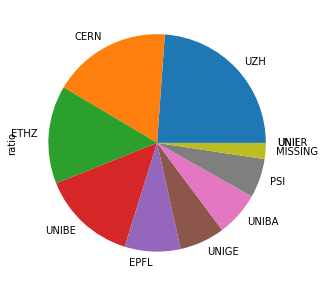

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
df_institutions.iloc[1:].plot.pie(y='ratio', figsize=(5, 5), legend=False)

In [45]:
# export du résultat final
df_institutions.to_csv(results_ratios, header=True, sep='\t')

In [46]:
# export des chiffres par publication avec les institutions
df_institutions_numbers.to_csv(results_numbers, header=True, index=False, sep='\t')